In [1]:
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as transF
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
num_epochs = 100
batch_size = 32
learning_rate = 0.001

train_dir = r'../input/animals-classification/Classification (Train_Val)/Train'
test_dir = r'../input/animals-classification/Classification (Train_Val)/Val'

In [4]:
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transF.pad(image, padding, 0, 'constant')

In [5]:
train_transforms = transforms.Compose([
                                       SquarePad(),
                                       transforms.Resize((330, 330)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.3909, 0.3764, 0.3076],
                                                            [0.3262, 0.3165, 0.3023])])

test_transforms = transforms.Compose([SquarePad(),
                                      transforms.Resize((330, 330)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.3909, 0.3764, 0.3076],
                                                           [0.3262, 0.3165, 0.3023])])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

368 74


In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean = [0.5199, 0.5007, 0.4075], std = [0.2689, 0.2625, 0.2789])


torch.Size([32, 3, 330, 330]) torch.Size([32])


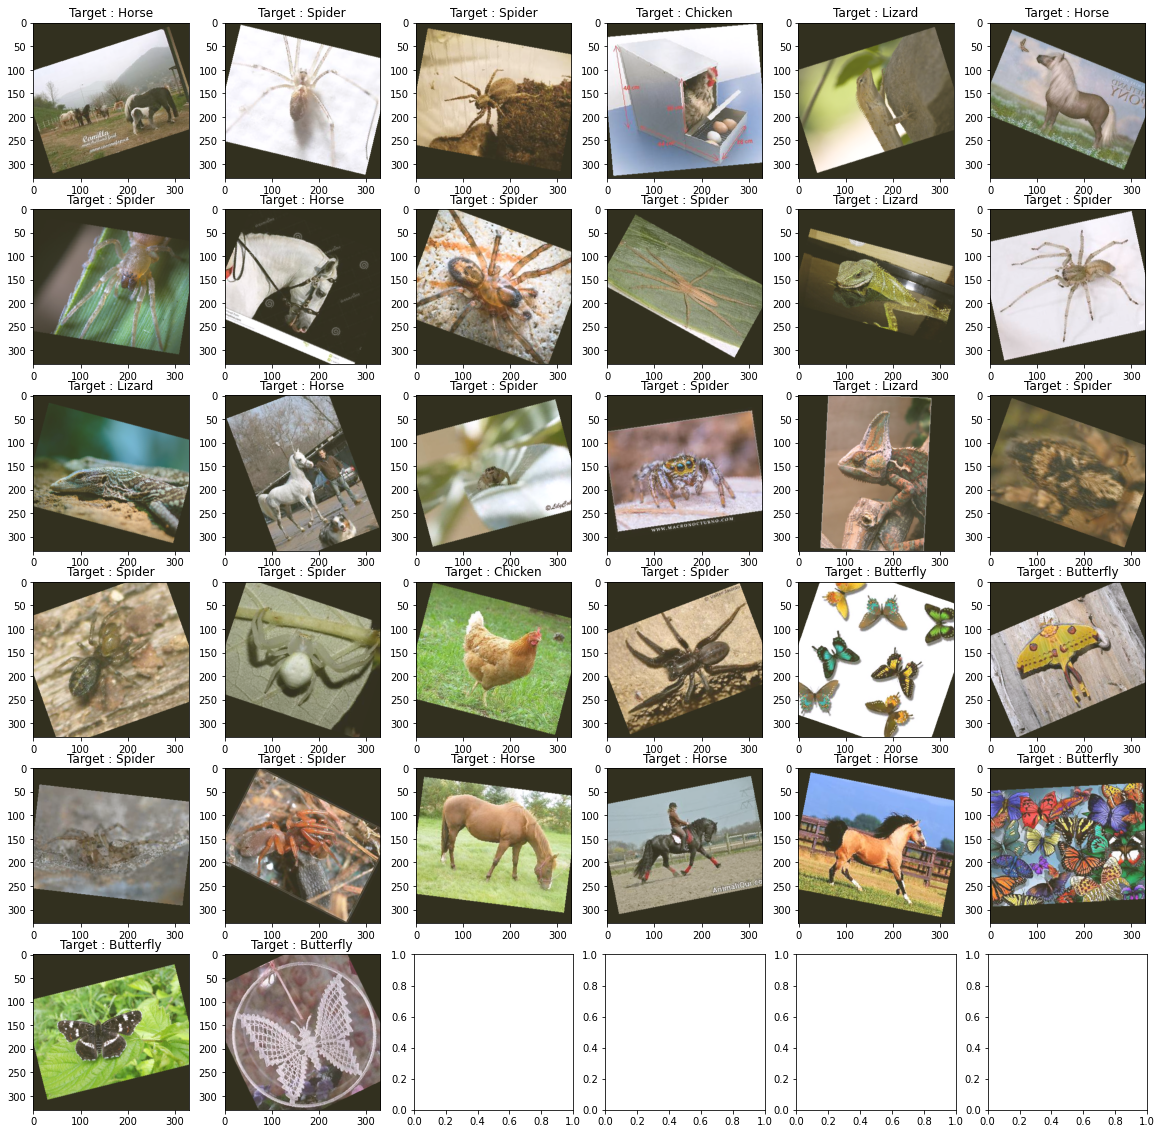

In [7]:
target_names = ['Butterfly', 'Chicken', 'Horse', 'Lizard', 'Spider']
images,labels = next(iter(train_loader))
print(images.shape, labels.shape)
plt.subplots(6,6 , figsize=(20,20))
for i, (image, label) in enumerate(zip(images,labels)):
    plt.subplot(6, 6, i+1)
    temp = unorm(image)
    plt.imshow( temp.permute(1, 2, 0))
    plt.title("Target : " + target_names[label.numpy()])
plt.show()

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [9]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=5):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 , num_classes)
        self.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(512, num_classes))


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) 
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [10]:
def ResNet152():
    layers=[3, 8, 36, 3]
    model = ResNet(BasicBlock, layers)
    return model
def ResNet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model
def ResNet18():
    layers=[2, 2, 2, 2]
    model = ResNet(BasicBlock, layers)
    return model

In [11]:
model = ResNet34()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def train(model, train_loader):
    model.train()
    train_acc, correct_train, train_loss, target_count = 0, 0, 0, 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # accuracy
        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_train += (labels == predicted).sum().item()
        train_acc = (100 * correct_train) / target_count
    return train_acc, train_loss / target_count

In [13]:
def validate(model,val_loader):
    model.eval()
    val_acc, correct_val, val_loss, target_count = 0, 0, 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        target_count += labels.shape[0]
        correct_val += (labels == predicted).sum().item()
        val_acc = (100 * correct_val) / target_count
    return val_acc, val_loss / target_count 

In [14]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

# Early stopping
the_last_loss = 100
patience = 10
trigger_times = 0
isStopped = False

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

for epoch in range(0, num_epochs):
    
    train_acc, train_loss = train(model, train_loader)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    
    val_acc,val_loss = validate(model, test_loader)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)
    
    print("Epoch {0}: train_acc {1} \t train_loss {2} \t val_acc {3} \t val_loss {4}".format(epoch, train_acc, train_loss, val_acc, val_loss))
    
    the_current_loss = val_loss
    
    if the_current_loss > the_last_loss:
        trigger_times += 1
        print('trigger times: ', trigger_times)
        if trigger_times >= patience:
            print('Early stopping! at epoch {0}'.format(epoch))
            isStopped = True
            break
    else:
        print('trigger times: 0')
        trigger_times = 0
        the_last_loss = the_current_loss
        if not isStopped:
            torch.save(model.state_dict(), 'mymodel.pt')
            print('Validation loss {:.6f}.  Saving model ...'.format(the_current_loss))

Epoch 0: train_acc 39.64155270534273 	 train_loss 0.04622771526713506 	 val_acc 37.16360529688168 	 val_loss 0.04767125333185534
trigger times: 0
Validation loss 0.047671.  Saving model ...
Epoch 1: train_acc 52.008833772190606 	 train_loss 0.038188896101839245 	 val_acc 50.405809483126866 	 val_loss 0.04194436694301636
trigger times: 0
Validation loss 0.041944.  Saving model ...
Epoch 2: train_acc 58.32837849316232 	 train_loss 0.0342965853768137 	 val_acc 60.35882101665955 	 val_loss 0.03300874627130452
trigger times: 0
Validation loss 0.033009.  Saving model ...
Epoch 3: train_acc 65.14906990571647 	 train_loss 0.029211240607394263 	 val_acc 63.73344724476719 	 val_loss 0.02942261616677517
trigger times: 0
Validation loss 0.029423.  Saving model ...
Epoch 4: train_acc 69.74433024717574 	 train_loss 0.025640018058392243 	 val_acc 70.65356685177275 	 val_loss 0.02418081580141272
trigger times: 0
Validation loss 0.024181.  Saving model ...
Epoch 5: train_acc 72.20759364647924 	 train_l

In [15]:
model.load_state_dict(torch.load('mymodel.pt'))

<All keys matched successfully>

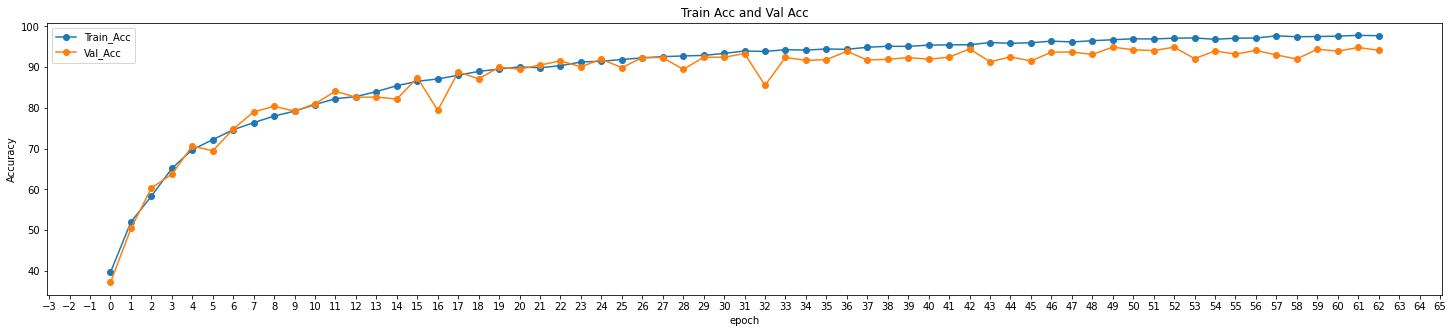

In [16]:
plt.figure(figsize=(25,5))
plt.plot(train_acc_history,'-o')
plt.plot(val_acc_history,'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Acc','Val_Acc'])
plt.title('Train Acc and Val Acc')
plt.show()

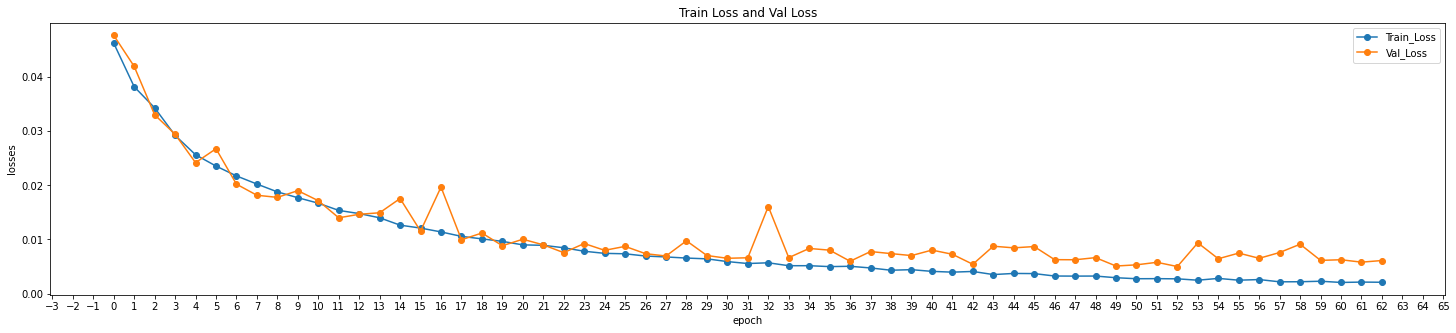

In [17]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train_Loss','Val_Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [18]:
model.eval()
pred_list = []
label_list = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    running_loss=0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)
        pred_list.extend(predictions.cpu().numpy())
        label_list.extend(labels.cpu().numpy())
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {acc} %')

Accuracy of the network on the test images: 94.91670226398975 %


In [19]:
from sklearn.metrics import confusion_matrix
cm_percentage=confusion_matrix(label_list,pred_list, normalize='true')
cm_number=confusion_matrix(label_list,pred_list)

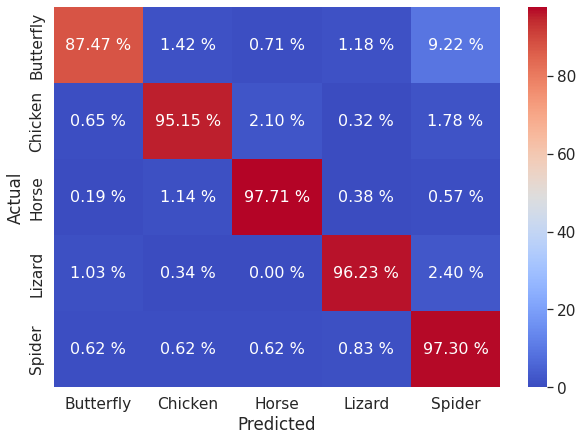

In [20]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

target_names = ['Butterfly', 'Chicken', 'Horse', 'Lizard', 'Spider']
df_cm = pd.DataFrame(cm_percentage*100, range(5), range(5))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True,cmap='coolwarm', annot_kws={"size": 16}, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

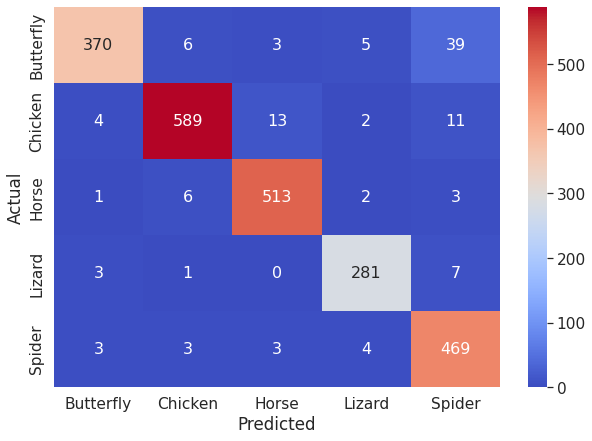

In [21]:
cm_number = cm_number.astype(int)
df_cm = pd.DataFrame(cm_number, range(5), range(5))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, cmap='coolwarm', annot_kws={"size": 16}, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)